In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from alibi.explainers import PartialDependence, plot_pd, PartialDependenceVariance, plot_pd_variance

c:\Users\admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\admin\anaconda3\lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
c:\Users\admin\anaconda3\lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df = df.drop(['dteday', 'registered', 'casual'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,temp,atemp,hum,windspeed,cnt,workday,weather,days_since_2011,cnt_2d_bfr
0,3,WINTER,2011,JAN,N,MON,1.229108,22.439770,43.7273,16.636703,1349,Y,GOOD,2,985
1,4,WINTER,2011,JAN,N,TUE,1.400000,23.212148,59.0435,10.739832,1562,Y,GOOD,3,801
2,5,WINTER,2011,JAN,N,WED,2.666979,23.795180,43.6957,12.522300,1600,Y,GOOD,4,1349
3,6,WINTER,2011,JAN,N,THU,1.604356,23.929106,51.8261,6.000868,1606,Y,GOOD,5,1562
4,7,WINTER,2011,JAN,N,FRI,1.236534,23.100526,49.8696,11.304642,1510,Y,MISTY,6,1600


In [3]:
feature_names = df.columns.tolist()
feature_names.remove('cnt')

target_names = ['Number of Bikes']
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workday', 'weather']

categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(cn) for cn in feature_names if cn not in categorical_columns_names]

X = df[feature_names]
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(categorical_columns_indices, numerical_columns_indices)

[1, 2, 3, 4, 5, 10, 11] [0, 6, 7, 8, 9, 12, 13]


In [4]:
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

categorical_names = {i:list(v) for i, v in zip(categorical_columns_indices, oe.categories_)}
categorical_names

{1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
 2: [2011, 2012],
 3: ['APR',
  'AUG',
  'DEC',
  'FEB',
  'JAN',
  'JUL',
  'JUN',
  'MAR',
  'MAY',
  'NOV',
  'OCT',
  'SEP'],
 4: ['N', 'Y'],
 5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
 10: ['N', 'Y'],
 11: ['BAD', 'GOOD', 'MISTY']}

In [5]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_columns_indices),
                                  ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns_indices)])
preprocessor.fit(X_train)
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [6]:
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
predictor.score(X_train_ohe, y_train), predictor.score(X_test_ohe, y_test)

(0.9817083893337574, 0.8843882268668817)

In [8]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [9]:
explainer = PartialDependence(predictor=prediction_fn, feature_names=feature_names, target_names=target_names, categorical_names=categorical_names)

In [10]:
features = [feature_names.index('temp'), feature_names.index('hum'), feature_names.index('windspeed'), feature_names.index('season')]
features

[6, 8, 9, 1]

In [11]:
exp = explainer.explain(X=X_train, features=features, kind='average')
exp

Explanation(meta={
  'name': 'PartialDependence',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'kind': 'average',
              'percentiles': (0.0, 1.0),
              'grid_resolution': 100,
              'feature_names': ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'workday', 'weather', 'days_since_2011', 'cnt_2d_bfr'],
              'categorical_names': {
                                     1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
                                     2: [2011, 2012],
                                     3: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'],
                                     4: ['N', 'Y'],
                                     5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
                                     10: ['N', 'Y'],
                                     11: ['BAD', 'GOOD', 'MISTY']}
                            

array([[<AxesSubplot:xlabel='temp', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='hum', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='windspeed', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='season', ylabel='Number of Bikes'>, None,
        None]], dtype=object)

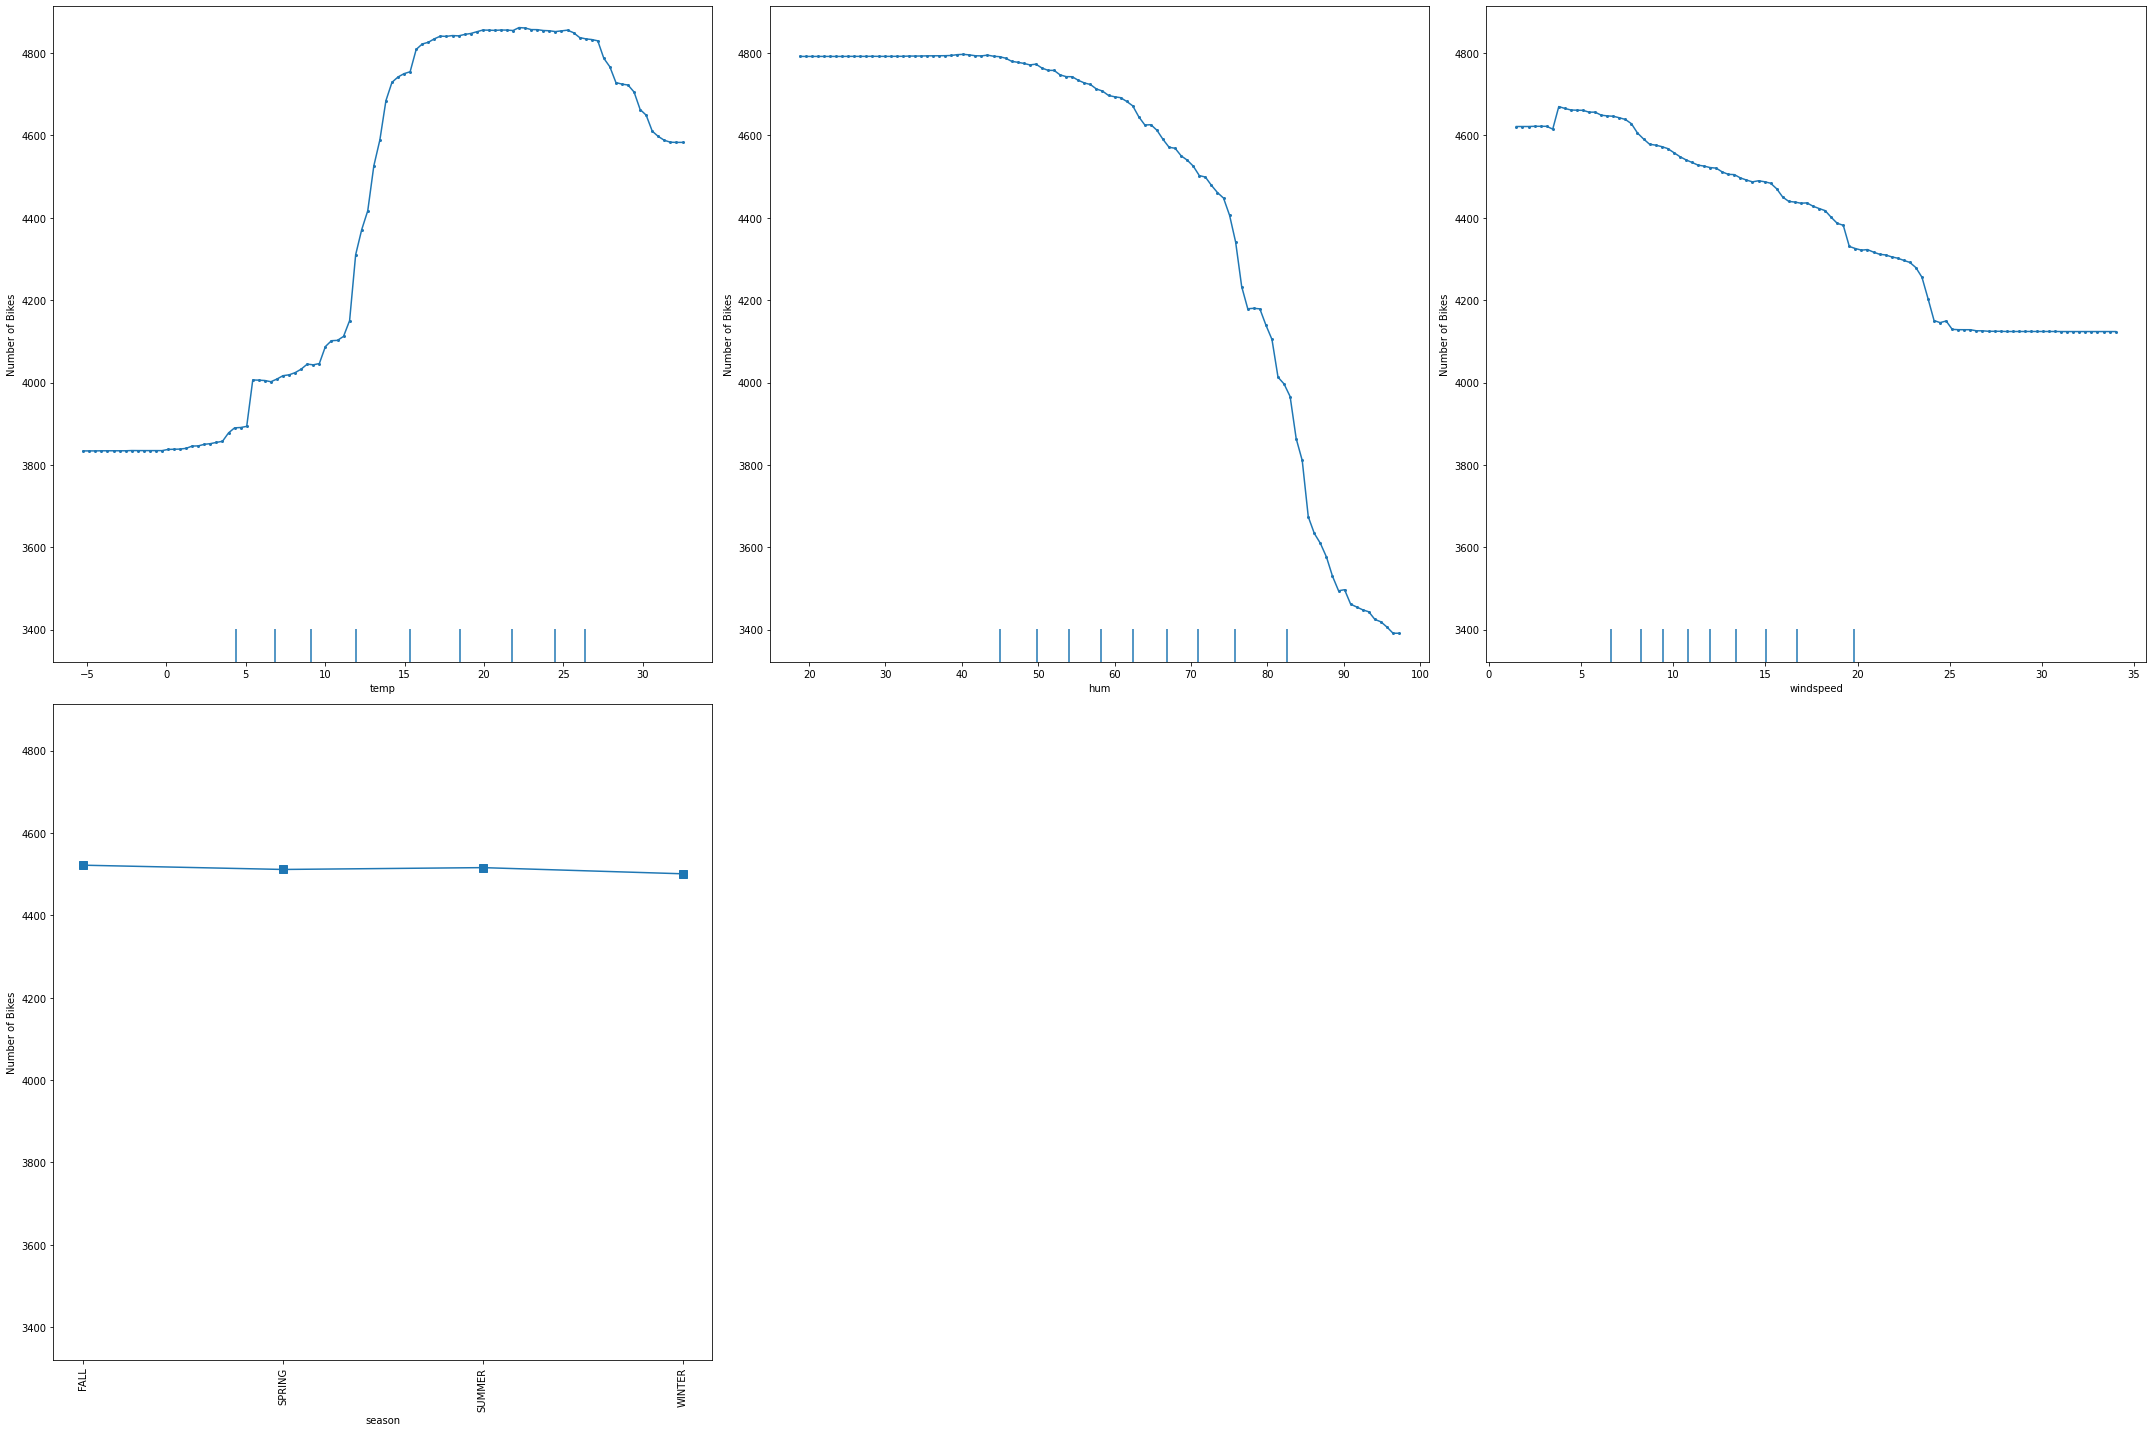

In [12]:
plot_pd(exp=exp, fig_kw={'figheight':20, 'figwidth':30})

In [13]:
feature_interaction = [(feature_names.index('temp'), feature_names.index('windspeed')),
                       (feature_names.index('mnth'), feature_names.index('weather'))]

In [14]:
exp_int = explainer.explain(X=X_train, features=feature_interaction, kind='average')

array([[<AxesSubplot:xlabel='temp', ylabel='windspeed'>,
        <AxesSubplot:xlabel='weather', ylabel='mnth'>]], dtype=object)

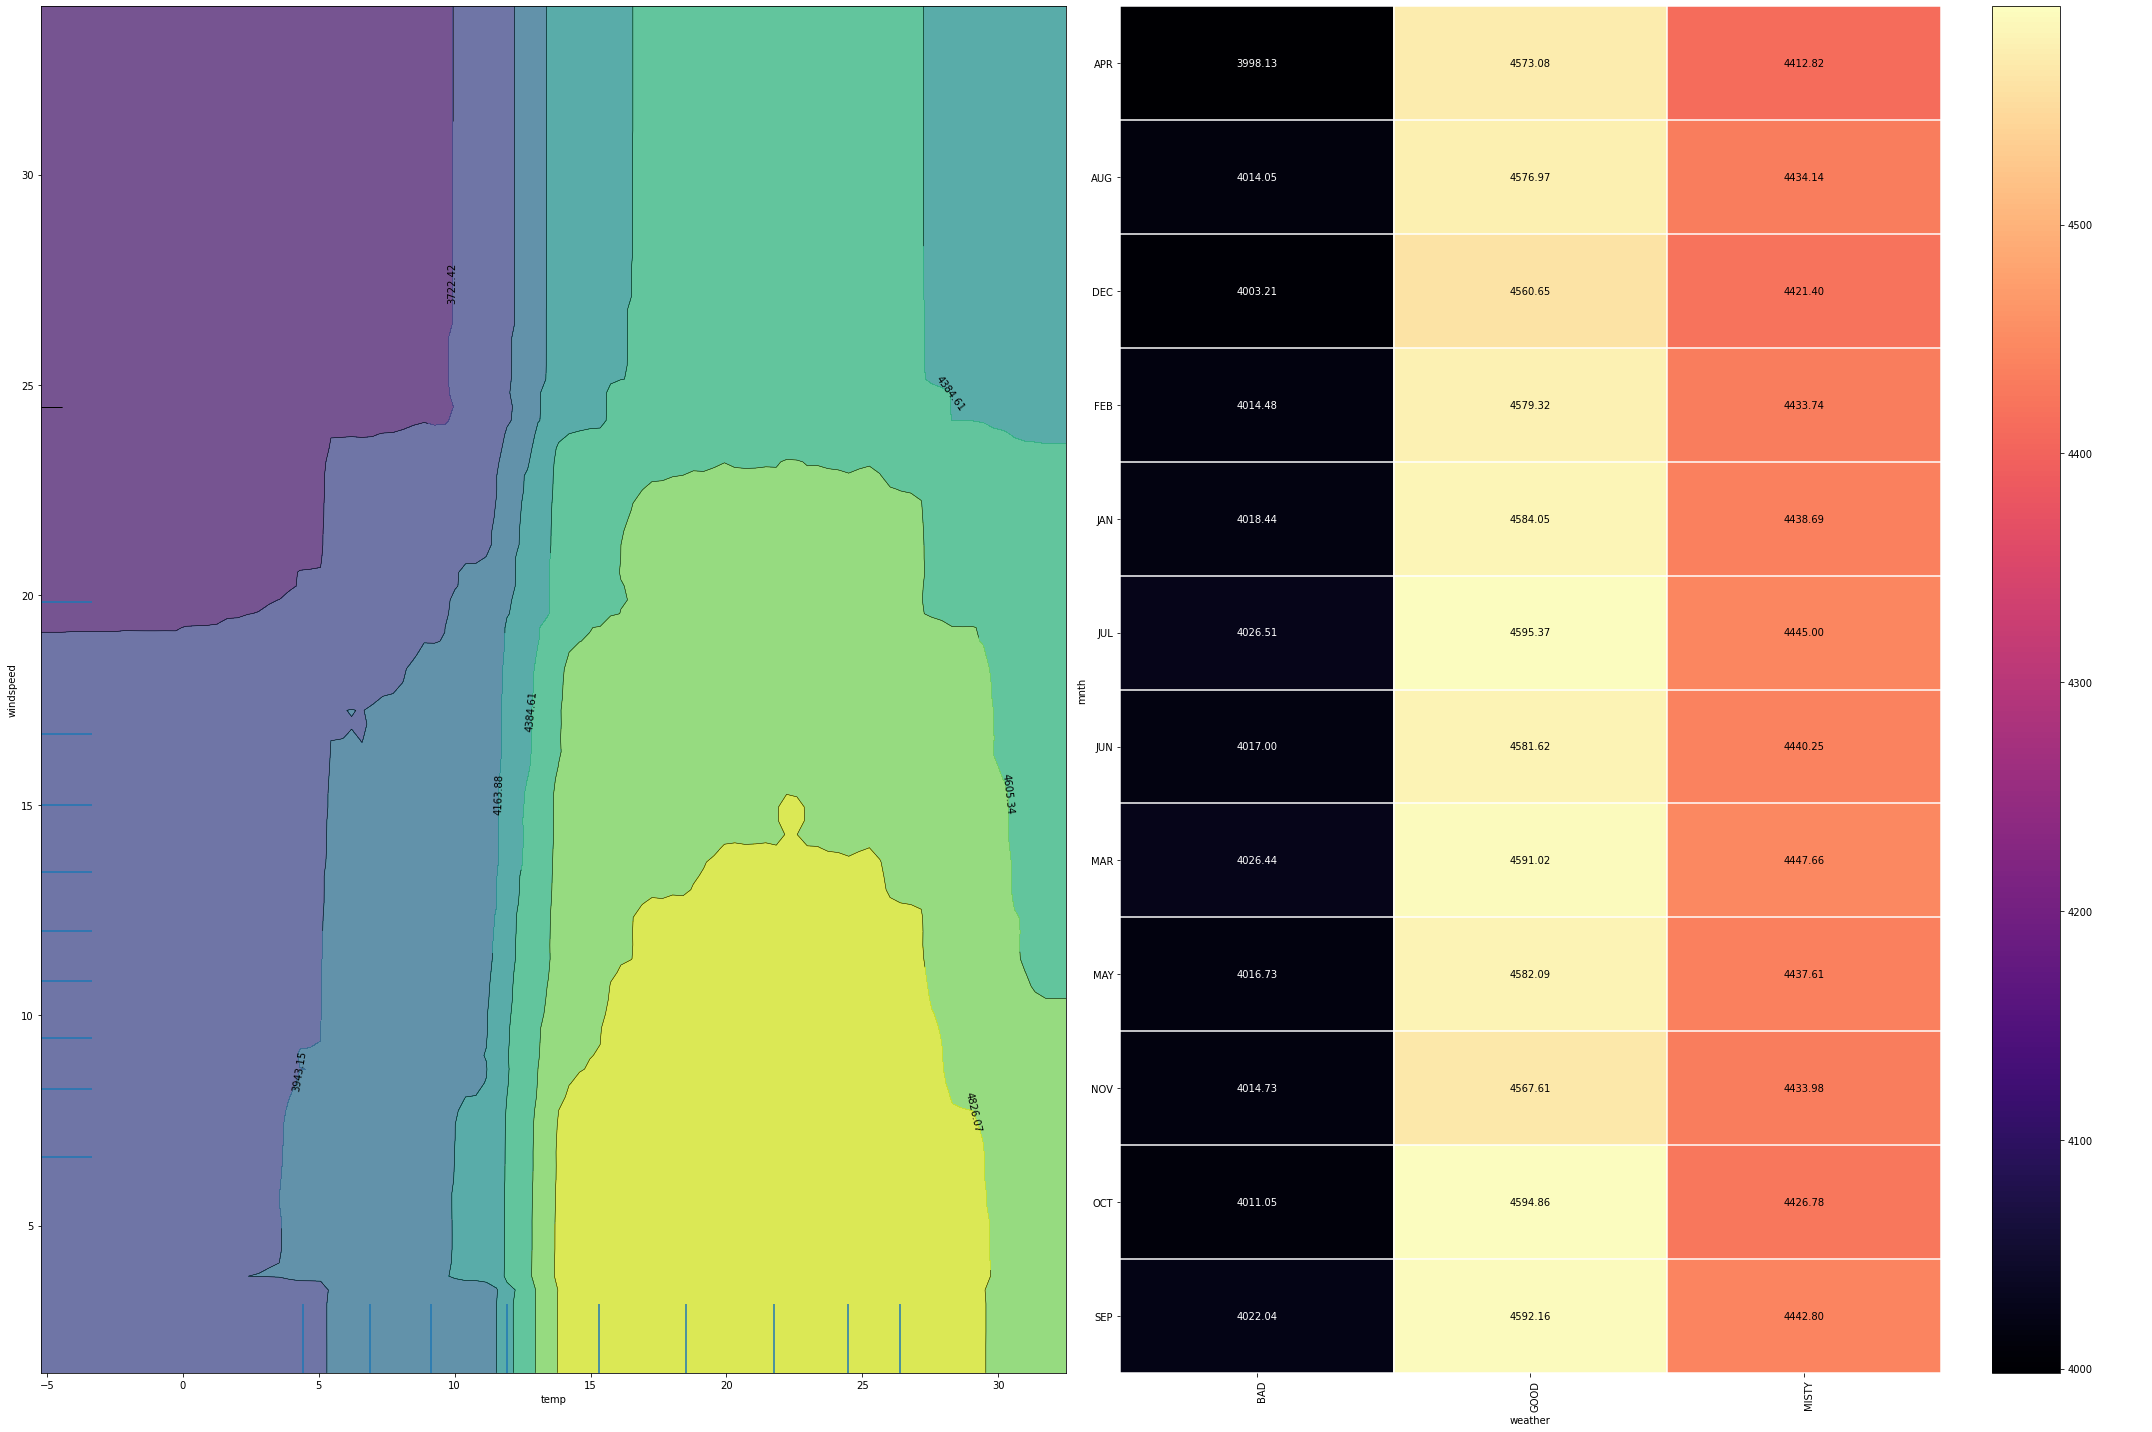

In [15]:
plot_pd(exp=exp_int, fig_kw={'figheight':20, 'figwidth':30})

In [16]:
pd_var = PartialDependenceVariance(predictor=prediction_fn, feature_names=feature_names, categorical_names=categorical_names, target_names=target_names)

In [17]:
exp_importance_all = pd_var.explain(X=X_train, method='importance')
exp_importance_all

Explanation(meta={
  'name': 'PartialDependenceVariance',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'percentiles': (0.0, 1.0),
              'grid_resolution': 100,
              'feature_names': ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'workday', 'weather', 'days_since_2011', 'cnt_2d_bfr'],
              'categorical_names': {
                                     1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
                                     2: [2011, 2012],
                                     3: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'],
                                     4: ['N', 'Y'],
                                     5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
                                     10: ['N', 'Y'],
                                     11: ['BAD', 'GOOD', 'MISTY']}
                                   ,
              't

array([[<AxesSubplot:title={'center':'Number of Bikes'}, xlabel='Feature importance'>]],
      dtype=object)

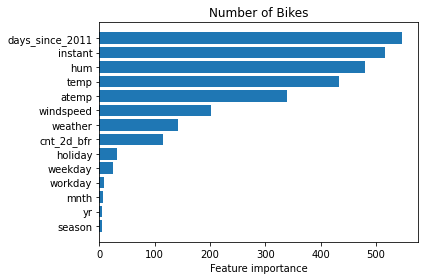

In [18]:
plot_pd_variance(exp=exp_importance_all)

array([[<AxesSubplot:title={'center':'imp(days_since_2011) = 547.663'}, xlabel='days_since_2011', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(instant) = 515.528'}, xlabel='instant', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(hum) = 479.480'}, xlabel='hum', ylabel='Number of Bikes'>],
       [<AxesSubplot:title={'center':'imp(temp) = 432.696'}, xlabel='temp', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(atemp) = 339.385'}, xlabel='atemp', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(windspeed) = 202.574'}, xlabel='windspeed', ylabel='Number of Bikes'>],
       [<AxesSubplot:title={'center':'imp(weather) = 141.522'}, xlabel='weather', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(cnt_2d_bfr) = 115.624'}, xlabel='cnt_2d_bfr', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(holiday) = 31.043'}, xlabel='holiday', ylabel='Number of Bikes'>],
       [<

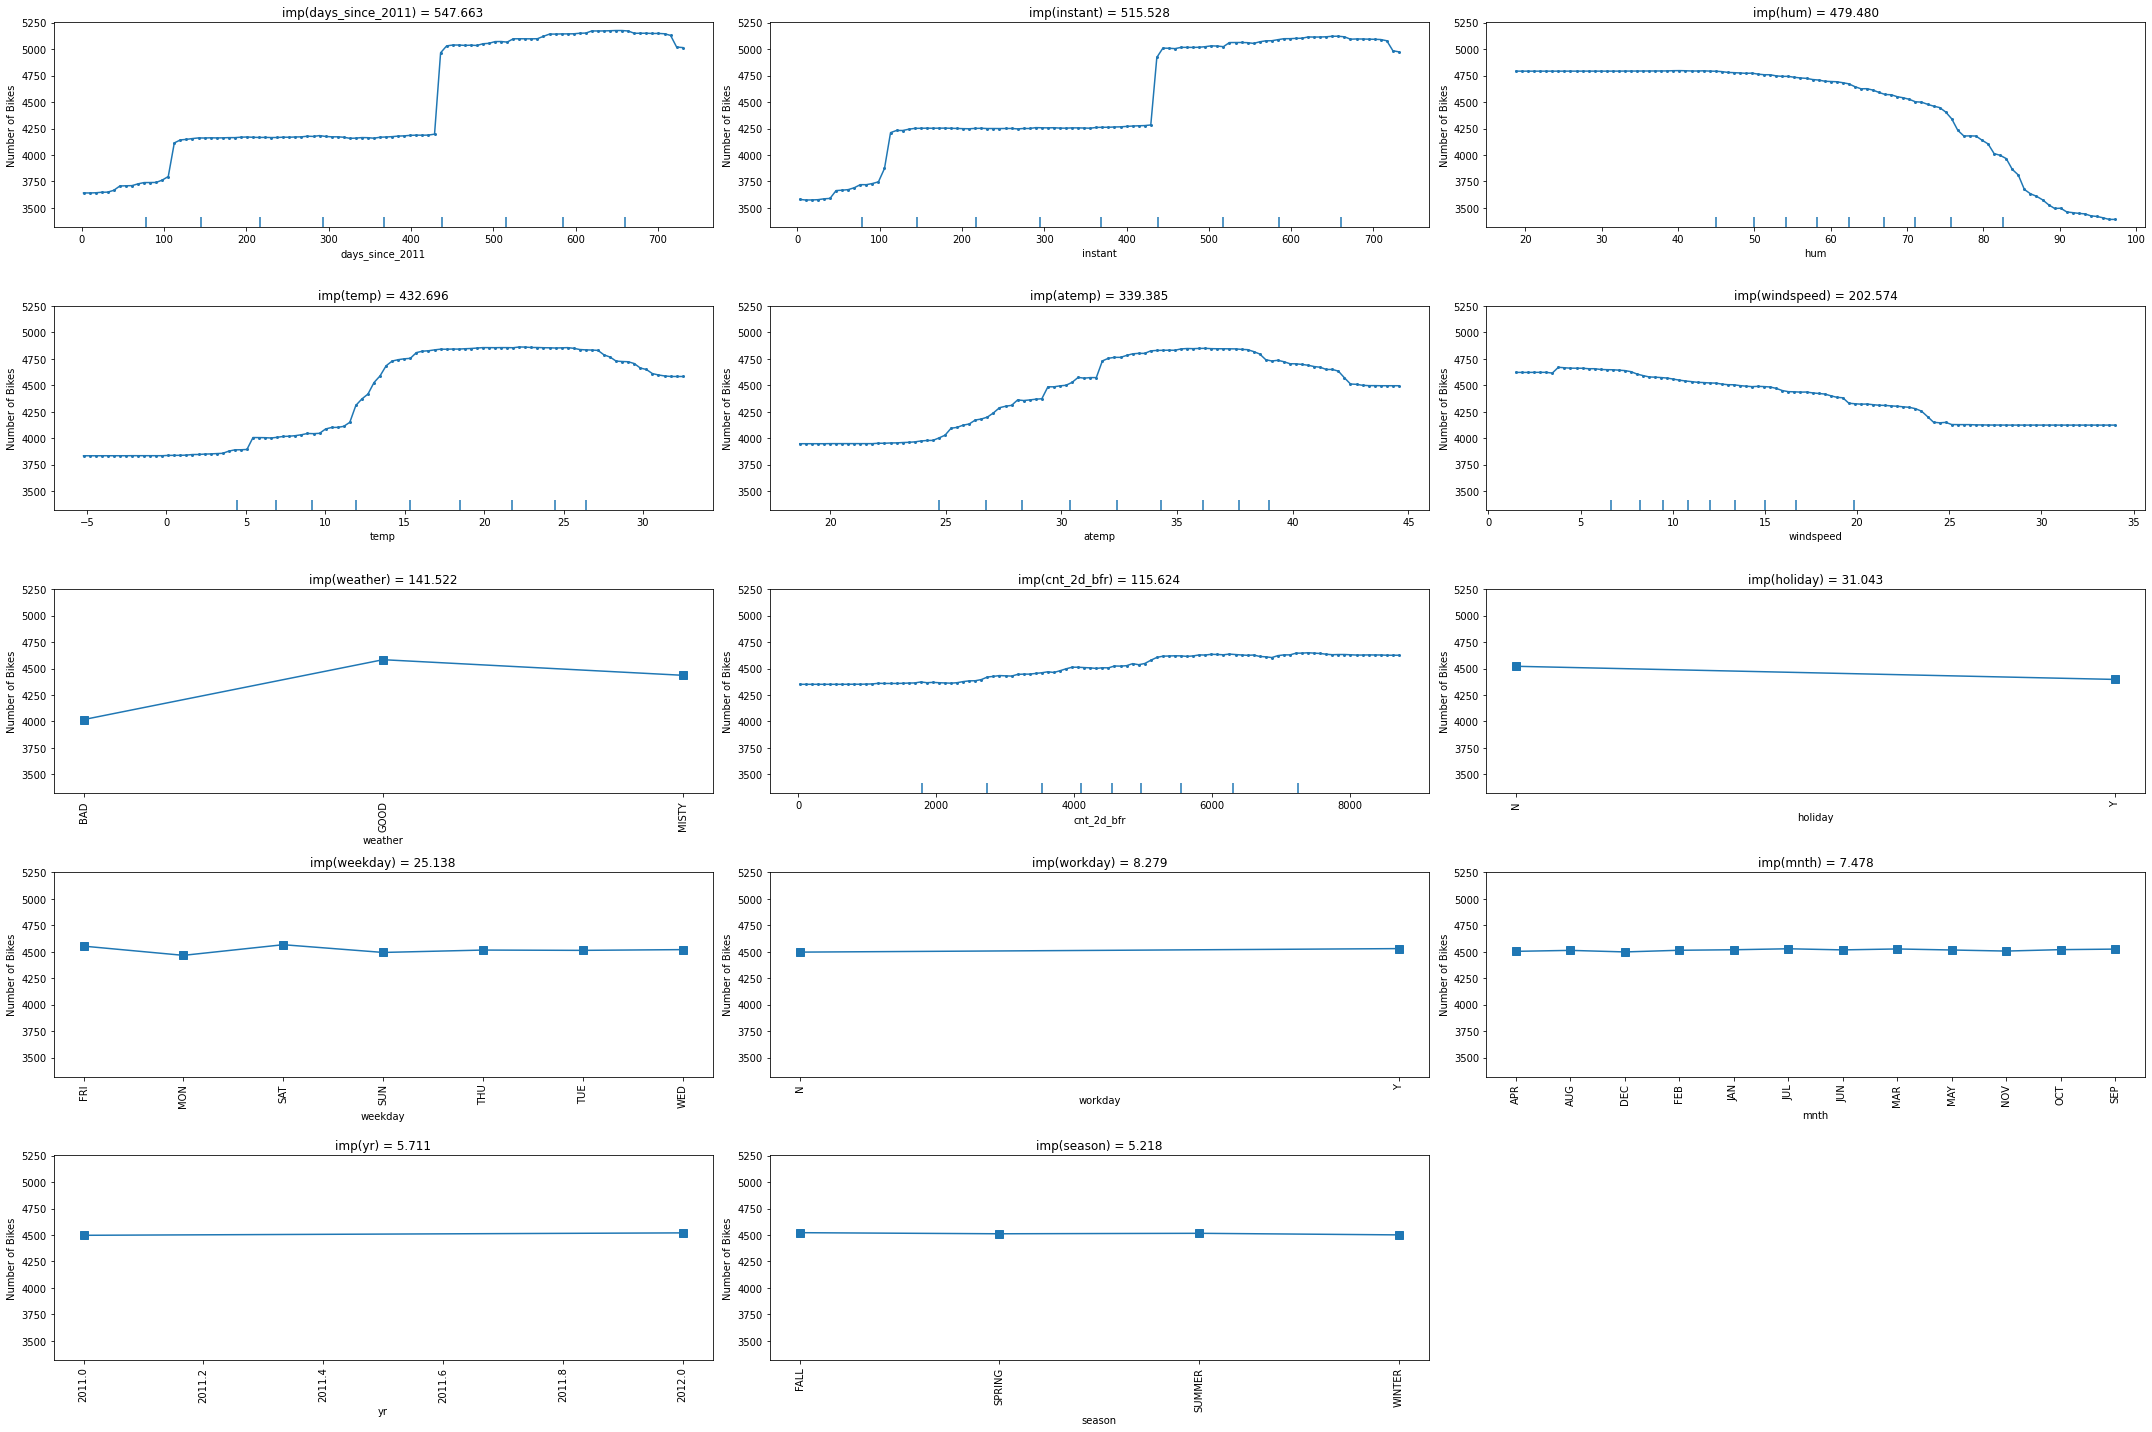

In [20]:
plot_pd_variance(exp=exp_importance_all, summarise=False, fig_kw={'figheight':20, 'figwidth':30})